No aprendizado de máquina e na estatística, a seleção de recursos, também conhecida como seleção de variáveis, seleção de atributos ou seleção de subconjuntos de variáveis, é o processo de seleção de um subconjunto de recursos relevantes (variáveis, preditores) para uso na construção do modelo.

 As técnicas de seleção de recursos são usadas por vários motivos:
     * simplificação de modelos para facilitar a interpretação por pesquisadores / usuários;
     * tempo de treinamento mais curto;
     * reduz o processo de overfitting

## O que seria selecionar parâmetros?

Parâmetros Selecionados com a utilização de filtros, podem ser usados como entrada de qualquer modelo de machine learning.

Os métodos se diferem aos tipos de dados:
Univariado   -> Análise de cada variável separadamente
Bivariado    -> Método de análise de duas variáveis (causa/efeito)
Multivariado -> Métodos de análise de relações de múltiplas variáveis dependentes ou independentes

## Qual o melhor Método?

Como tudo na vida, não existe o modelo perfeito mas o que se adequa melhor aos seus dados. Como cientista de dados, uma de nossas 
funções é testar o máximo de hipóteses para melhorar o desempenho geral do aprendizado, evitando o overfitting e estudando a relaçao
os dados sempre da melhor forma.

## Download dos Dados
* https://github.com/philipesantos136/Portfolio/tree/master/Feature-Selection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold

In [3]:
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
!pip install -q scikit-plot
import scikitplot as skplt

Using TensorFlow backend.


In [4]:
data = pd.read_csv('santander.csv', nrows = 20000)
data.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [5]:
X = data.drop('TARGET', axis = 1)
y = data['TARGET']

X.shape, y.shape

((20000, 370), (20000,))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

## Balanceando os Dados

1    569
0    569
Name: TARGET, dtype: int64


VarianceThreshold(threshold=0)

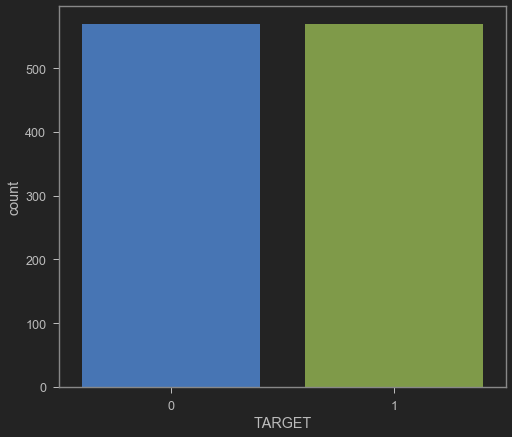

In [7]:
# aplicando o UnderSampler
rus = RandomUnderSampler()
X_rus_train, y_rus_train = rus.fit_sample(X_train, y_train)

# checando o balanceamento das classes
print(pd.Series(y_rus_train).value_counts())

# plotando a nova distribuição das classes
sns_plot = sns.countplot(y_rus_train);
plt.savefig("balanced.png")

constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(X_rus_train)

### Remoção de parâmetros constantes

In [8]:
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(X_rus_train)

VarianceThreshold(threshold=0)

In [9]:
constant_filter.get_support().sum()

213

In [10]:
X_train_filter = constant_filter.transform(X_rus_train)
X_test_filter = constant_filter.transform(X_test)

X_train_filter.shape, X_test_filter.shape, X_train.shape

((1138, 213), (6000, 213), (14000, 370))

## Remoção de Parâmetros Semi-Constantes

In [11]:
quasi_constant_filter = VarianceThreshold(threshold=0.01)

In [12]:
quasi_constant_filter.fit(X_train_filter)

VarianceThreshold(threshold=0.01)

In [13]:
quasi_constant_filter.get_support().sum()

194

In [14]:
X_train_quasi_filter = quasi_constant_filter.transform(X_train_filter)
X_test_quasi_filter = quasi_constant_filter.transform(X_test_filter)

X_train_quasi_filter.shape, X_test_quasi_filter.shape

((1138, 194), (6000, 194))

## Parâmetros Duplicados

In [15]:
X_train_T = X_train_quasi_filter.T
X_test_T = X_test_quasi_filter.T

In [16]:
X_train_T = pd.DataFrame(X_train_T)
X_test_T = pd.DataFrame(X_test_T)

In [17]:
X_train_T.shape, X_test_T.shape

((194, 1138), (194, 6000))

In [18]:
X_train_T.duplicated().sum()

24

In [19]:
duplicated_features = X_train_T.duplicated()

In [20]:
features_to_keep = [not index for index in duplicated_features]

In [21]:
X_train_unique = X_train_T[features_to_keep].T
X_test_unique = X_test_T[features_to_keep].T

In [22]:
X_train_unique.shape, X_train.shape

((1138, 170), (14000, 370))

## Criando modelo e comparando as performances

In [23]:
def run_randomForest(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    # plotar a matrix de confusão
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
    print("Classification Report")
    print(metrics.classification_report(y_test, y_pred, labels = [1, 0],digits=4))
    print()

Classification Report
              precision    recall  f1-score   support

           1     0.0998    0.6598    0.1734       244
           0     0.9811    0.7477    0.8487      5756

    accuracy                         0.7442      6000
   macro avg     0.5404    0.7038    0.5110      6000
weighted avg     0.9452    0.7442    0.8212      6000


Wall time: 887 ms


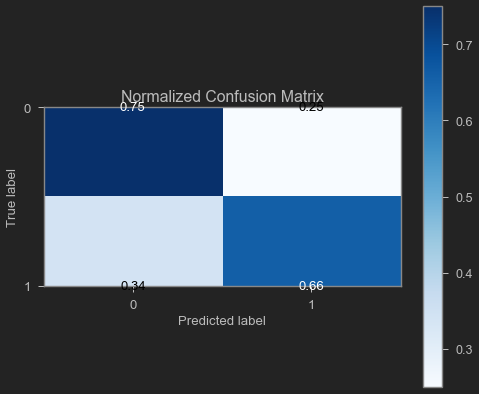

In [24]:
%%time
#Modelo com os dados balanceados
run_randomForest(X_train_unique, X_test_unique, y_rus_train, y_test)

Classification Report
              precision    recall  f1-score   support

           1     0.2857    0.0164    0.0310       244
           0     0.9599    0.9983    0.9787      5756

    accuracy                         0.9583      6000
   macro avg     0.6228    0.5073    0.5049      6000
weighted avg     0.9325    0.9583    0.9402      6000


Wall time: 3.79 s


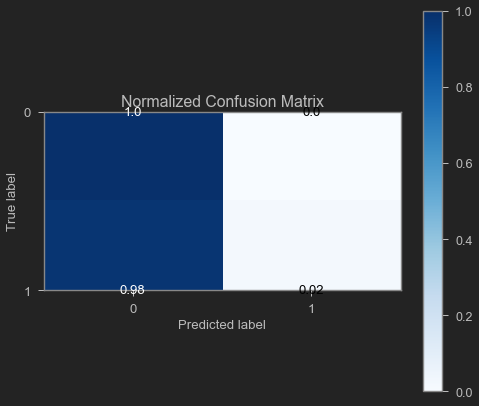

In [25]:
%%time
run_randomForest(X_train, X_test, y_train, y_test)

## Referências
* Gareth James; Daniela Witten; Trevor Hastie; Robert Tibshirani (2013). An Introduction to Statistical Learning. Springer. p. 204.
* (Burns, 2000; M. Hill & A. Hill, 2000; Thomas & Nelson, 1996). Sin.: Estatística Univariável (Dorsch et al., 2001); Estatística a uma dimensão (Dagnelie, n.d.).
* Estatística Bivariável (Dorsch et al., 2001); Estatística a duas dimensões (Dagnelie, n.d.)
* Estatística Multivariável (Dorsch et al., 2001); Estatística a três ou mais dimensões (Dagnelie, n.d.).

## Sites
* https://en.wikipedia.org/wiki/Feature_selection
* https://alexandreramos.blogs.sapo.pt/7901.html